In [22]:

import numpy as np
from nilearn import datasets
from nilearn.input_data import NiftiLabelsMasker
from nilearn.image import index_img
import nibabel as nib
from sklearn.linear_model import BayesianRidge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold
# from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

brain_data = datasets.fetch_oasis_vbm(n_subjects=100)
yeo = datasets.fetch_atlas_schaefer_2018(n_rois=100) # this needs to be modified for some tasks
print('%i regions found in this atlas' % (len(np.unique(nib.load(yeo.maps).get_data().ravel())) 
- 1))
masker = NiftiLabelsMasker(labels_img=yeo.maps, standardize=True, 
memory='nilearn_cache')
input_variables = masker.fit_transform(brain_data.gray_matter_maps)
output_variable = np.array(brain_data.ext_vars.mf == b'F', dtype=np.int) # gives 1 for females and 0 for males

/usr/local/lib/python3.7/dist-packages/numpy/lib/npyio.py:2349: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  output = genfromtxt(fname, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  app.launch_new_instance()


100 regions found in this atlas


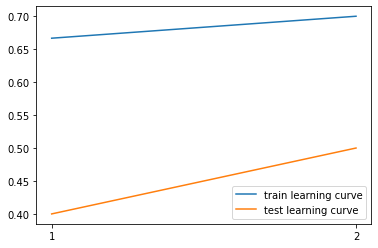

In [26]:
# for i in range(len(output_variable)):
#   if output_variable[i]==0:
#     output_variable[i] = -1
#   else:
#     output_variable[i] = 1

train_input = input_variables[:90]
train_output = output_variable[:90]

test_input = input_variables[90:]
test_output = output_variable[90:]

x_list = [] ### n_rois
train_y_list = [] ### accuracy
test_y_list = []


LogReg = BayesianRidge()

for degree in [1,2]:
  
  model = make_pipeline(PolynomialFeatures(degree),LogReg)
  model.fit(train_input, train_output)
  
  log_predict_train = model.predict(train_input)
  log_predict_output = model.predict(test_input)


  # here I encoded the output to 0 and 1, corresponding to output_variable
  for i in range(len(log_predict_train)):
    if log_predict_train[i] > 0:
      log_predict_train[i] = 1
    else:
      log_predict_train[i] = 0

  for i in range(len(log_predict_output)):
    if log_predict_output[i] > 0:
      log_predict_output[i] = 1
    else:
      log_predict_output[i] = 0

  test_accuracy = np.sum(log_predict_output == test_output)/len(test_output)
  train_accuracy = np.sum(log_predict_train == train_output)/len(train_output)

  x_list.append(degree) 
  train_y_list.append(train_accuracy) 
  test_y_list.append(test_accuracy)

plt.xticks(x_list)
plt.plot(x_list,train_y_list,label='train learning curve')
plt.plot(x_list,test_y_list,label='test learning curve')
  
plt.legend()
plt.show()